# Make LAS file from a striplog

In this recipe we will show how to take a striplog, convert one or more it's `Legend` attributes into curve data, and then this curve data to a new LAS file (issue #71).

First, import modules we might need

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.7.0'

## Making a striplog

In [2]:
from striplog import Striplog, Legend
imgfile = "data/images/P-129_280_1935.png"

In [3]:
legend = Legend.default(name='nsdoe')

In [4]:
strip = Striplog.from_image(imgfile, 280, 1935, legend=legend)

If we call the plot method on the striplog we get the whole striplog

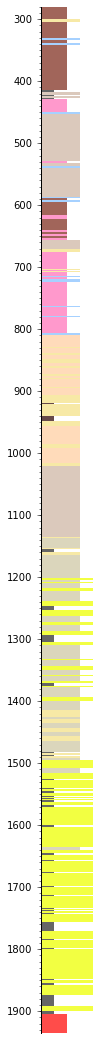

In [5]:
strip.plot(legend, ladder=True)

Convert the lithology component to log-like arrays called `liths`, and the width component to a log called `grainsize`.

In [6]:
liths, lbasis, _ = strip.to_log(legend=legend, return_meta=True)
grainsize = strip.to_log(basis=lbasis, legend=legend, legend_field='width')

Check data type are `liths` and `grainsize`?

In [7]:
type(liths)

numpy.ndarray

They are `ndarrays`.

Note at the default sample interval is 1.0 (m)

In [8]:
lbasis[1]-lbasis[0]

1.0

## Create a well object to hold on to these new logs

Striplog operations don't need to have an associated `well` object, however for log-like operations we'll need to use `welly`. 

To write our `liths` and `grainsize` logs to an LAS file, we need additional information about the well; details such as UWI, KB elevation, and so on. So let's create a `well` by starting with an LAS file with that has all of this information already.

In [9]:
from welly import Well

lasfile = 'data/las/P-129_out.LAS'  # existing LAS file to instantiate a well

well = Well.from_las(lasfile)  # creates a well object

well is now an object that contains only the curves from the `P-129_out.LAS`. In order to add data from our striplog , we need to convert `liths` and `grainsize`, to `Curve` objects.

In [10]:
from welly import Curve

We make a dictionary of parameters of things we want associated with the curve in the lasfile

In [11]:
litho_params = {'description': 'Peter Giles lithology',
                'mnemonic':'Lith'
               }

grain_params = {'description': 'Peter Giles grainsize',
                'mnemonic':'grsz'
               }

Pass the `ndarrays` and the parameters `dicts` into the `Curve` method

In [12]:
lithCurve = Curve(liths, lbasis, litho_params)
grainCurve = Curve(grainsize, lbasis, grain_params)

Add the new curves to the collection of curves that already exist in in `well.data` (another dictionary)

In [13]:
well.data['grsz'] = grainCurve
well.data['lith'] = lithCurve

We can change the step size of our new data from 1.0 m to 0.1524 m (standard), and convert it to the same start and step of another `Curve`. But we don't need to do this if we require the data to have the same sample rate. 

In [14]:
# lithCurve = lithCurve.to_basis(basis=)
# grainCurve = grainCurve.to_basis(step=0.1524)
# lithCurve

We don't need to do this prior to exporting. As welly's `to_las()` method takes care of the resampling of the curves to a common basis.

A simple plot,

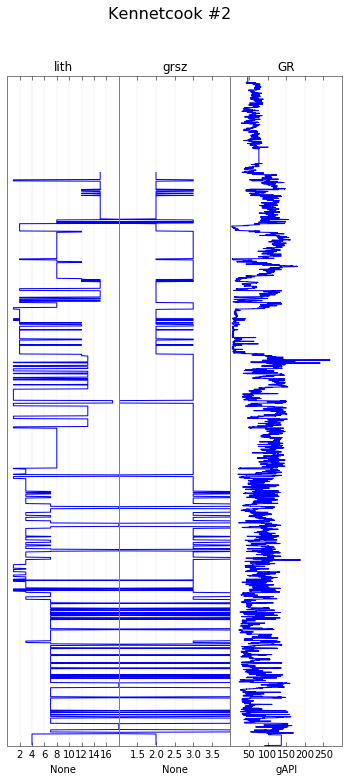

In [15]:
tracks = ['lith','grsz','GR']
well.plot(tracks=tracks)

Finally, in order to write these three curves (`lith`,`grnsz`, and `GR`) using we can pass a list of the mnemonics we want in output file, to the `well.to_las()` method.

In [16]:
keys = ['lith', 'grsz', 'GR']

In [17]:
well.to_las('data/las/P-140_GR_lith_grnsz.LAS', keys=keys)

## Striplog descriptions and numeric log data in one LAS file

Add the striplog to the well and export. This will put all the `striplog` stuff in the `~Other` section of the LAS file, whereas all the `Curve` data in the `~Ascii`
section.

In [18]:
well.data['strip'] = strip

In [19]:
keys = ['GR','strip']

In [20]:
well.to_las('data/las/P-140_GR_strip.LAS')

WellError: basis shift failed